# Denoising
**In this model, a Conv-based architecture strives to learn removing noises from images**
Dataset: Scikit-learn People faces (Labeled Faces in the Wild (LFW) dataset)

In [1]:
from sklearn.datasets import fetch_lfw_people
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from skimage.transform import resize
import os
from skimage.util import random_noise

data = fetch_lfw_people()
img = data['images']
T = data['target']
TN = data['target_names']

print(f"Data kyes: {data.keys()}")
print(f"\nTargets: {T}")
print(f"\nTarget Name: {TN[:10]}")
print(f"\nImages: {img.shape}")

Data kyes: dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

Targets: [227 522 492 ... 402 598 139]

Target Name: ['Aaron Sorkin' 'Abbas Kiarostami' 'Abdul Rahman' 'Abdullah Ahmad Badawi'
 'Abdullah al-Attiyah' 'Adoor Gopalakarishnan' 'Ahmad Masood'
 'Ahmed Ghazi' 'Ahmed Qureia' 'Aitor Gonzalez']

Images: (4424, 62, 47)


# Visualizing some of them

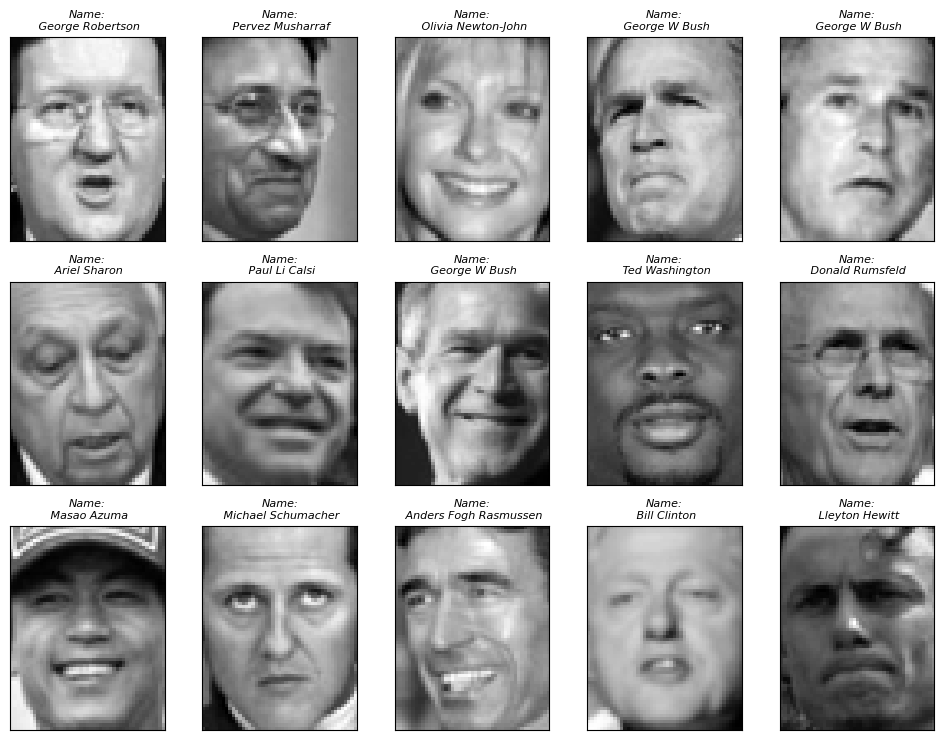

In [2]:

fig, ax = plt.subplots(3, 5, figsize = (12, 9))
for p in range(15):
    ax[p//5, p%5].imshow(img[p], cmap = 'gray')
    ax[p//5, p%5].set_title(f"Name:\n {TN[T[p]]}", fontsize = 8, fontstyle = 'italic')
    ax[p//5, p%5].set_xticks([])
    ax[p//5, p%5].set_yticks([])
plt.show()


# Convert into RGB

In [3]:
images_rgb = np.stack([img]*3, axis=-1)
print(f"Original shape: {img.shape}\nConverted data shape: {images_rgb.shape}")
print('-'*80)
print(f"Samples: {images_rgb.shape[0]}\nImage Size: {(images_rgb.shape[1], images_rgb.shape[2])}\nChannel: {images_rgb.shape[-1]}")

Original shape: (4424, 62, 47)
Converted data shape: (4424, 62, 47, 3)
--------------------------------------------------------------------------------
Samples: 4424
Image Size: (62, 47)
Channel: 3


# Generating Noisy Images
**Adding gaussian noise**

In [4]:

def add_noise(images):
    noisy_images = []
    for image in images:
        noisy_image = random_noise(image, mode='gaussian', var=0.1**2)
        noisy_images.append(noisy_image)
    return np.array(noisy_images)

noisy_images = add_noise(images_rgb)
print(f"Noisy Images Shape: {noisy_images.shape}")

Noisy Images Shape: (4424, 62, 47, 3)


**Comparing noisy and original images**

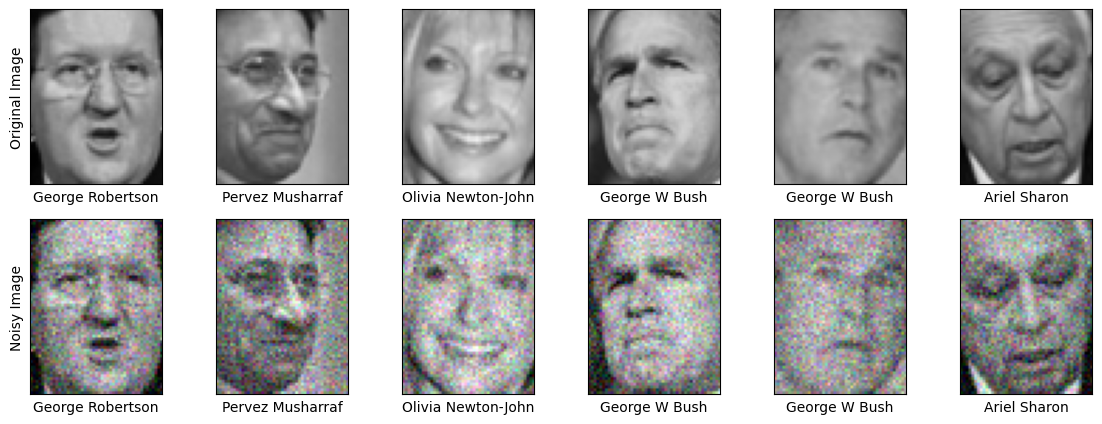

In [5]:
fig, ax = plt.subplots(2, 6, figsize = (14, 5))
for p in range(6):
    ax[0, p].imshow(images_rgb[p])
    ax[1, p].imshow(noisy_images[p])
    ax[0, 0].set_ylabel('Original Image')
    ax[1, 0].set_ylabel('Noisy Image')
    ax[0, p].set_xlabel(TN[T[p]])
    ax[1, p].set_xlabel(TN[T[p]])
    ax[0, p].set_xticks([])
    ax[0, p].set_yticks([])
    ax[1, p].set_xticks([])
    ax[1, p].set_yticks([])
plt.show()

# Dataset Pipeline

In [16]:
Xtr , Ytr = np.array(images_rgb[:-10]), np.array(noisy_images[:-10])
Xte , Yte = np.array(images_rgb[-10:]), np.array(noisy_images[-10:])
print(f"Xtr = {Xtr.shape}\nYtr = {Ytr.shape}\nXte = {Xte.shape}\nYte = {Yte.shape}")

Xtr = (4414, 62, 47, 3)
Ytr = (4414, 62, 47, 3)
Xte = (10, 62, 47, 3)
Yte = (10, 62, 47, 3)


# Our Conv2D-model

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout, UpSampling2D, InputLayer

Denoising_model = Sequential()
Denoising_model.add(InputLayer(input_shape=(Xtr.shape[1], Xtr.shape[2], Xtr.shape[3]))),
Denoising_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
Denoising_model.add(BatchNormalization()),
Denoising_model.add(Dropout(0.3)),
Denoising_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
Denoising_model.add(BatchNormalization()),
Denoising_model.add(Dropout(0.3)),
Denoising_model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

Denoising_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics = ['accuracy']
)

Denoising_model.summary()

c:\Users\Novin\.conda\envs\hamta2\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 47, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 47, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 47, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 47, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 62, 47, 3)      │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,147 (24.01 KB)

 Trainable params: 6,051 (23.64 KB)

 Non-trainable params: 96 (384.00 B)

# Train our model

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

ES = EarlyStopping(
    min_delta = 0.001,
    patience = 15,
    restore_best_weights = True
)

History = Denoising_model.fit(Xtr, Ytr, epochs=50, batch_size=16, validation_split=0.1, callbacks=[ES])

Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3339 - loss: 0.0112 - val_accuracy: 0.3337 - val_loss: 0.0138
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3337 - loss: 0.0110 - val_accuracy: 0.3340 - val_loss: 0.0144
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3333 - loss: 0.0109 - val_accuracy: 0.3332 - val_loss: 0.0100
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3336 - loss: 0.0110 - val_accuracy: 0.3335 - val_loss: 0.0115
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3335 - loss: 0.0108 - val_accuracy: 0.3327 - val_loss: 0.0105
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3332 - loss: 0.0108 - val_accuracy: 0.3333 - val_loss: 0.0099
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3333 - loss: 0.0108 - val_accuracy: 0.3320 - val_loss: 0.0117
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3331 - loss: 0.0106 - val_accu

<Axes: title={'center': 'Loss'}, xlabel='Iterations', ylabel='Loss Value'>

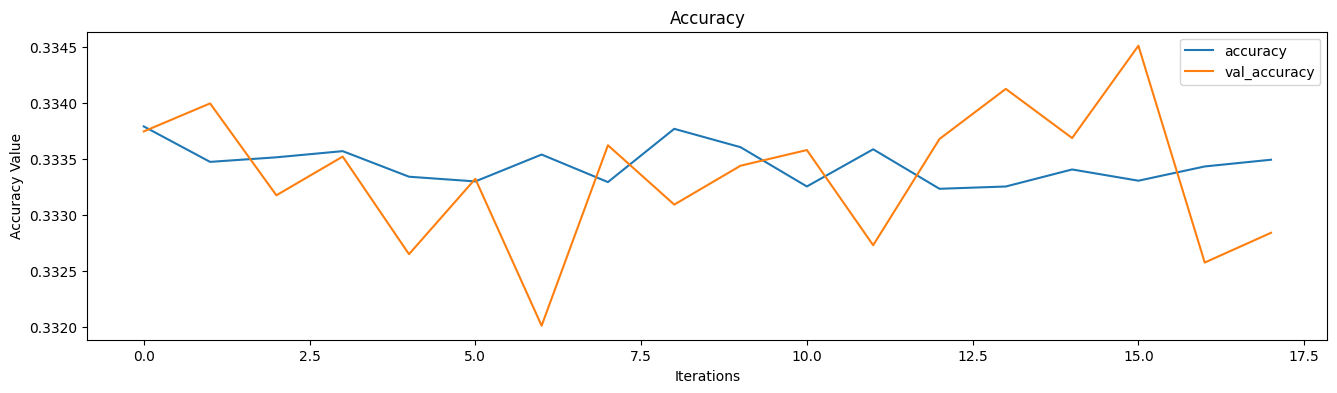

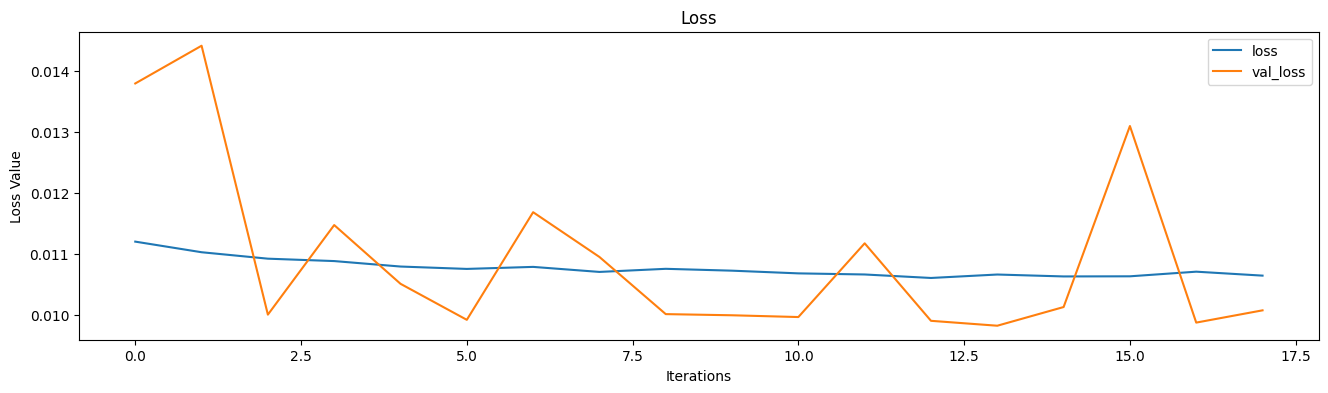

In [22]:
df = pd.DataFrame(History.history)
df[['accuracy', 'val_accuracy']].plot(kind='line', xlabel='Iterations', ylabel='Accuracy Value', title = 'Accuracy', figsize=(16, 4))
df[['loss', 'val_loss']].plot(kind='line', xlabel='Iterations', ylabel='Loss Value', title = 'Loss', figsize=(16, 4))

# Prediction

In [46]:
denoised_images = Denoising_model.predict(Xte)
print(f"The shape of denoised images (for testset) is as follows: {denoised_images.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
The shape of denoised images (for testset) is as follows: (10, 62, 47, 3)


# Make final comparison and see the results

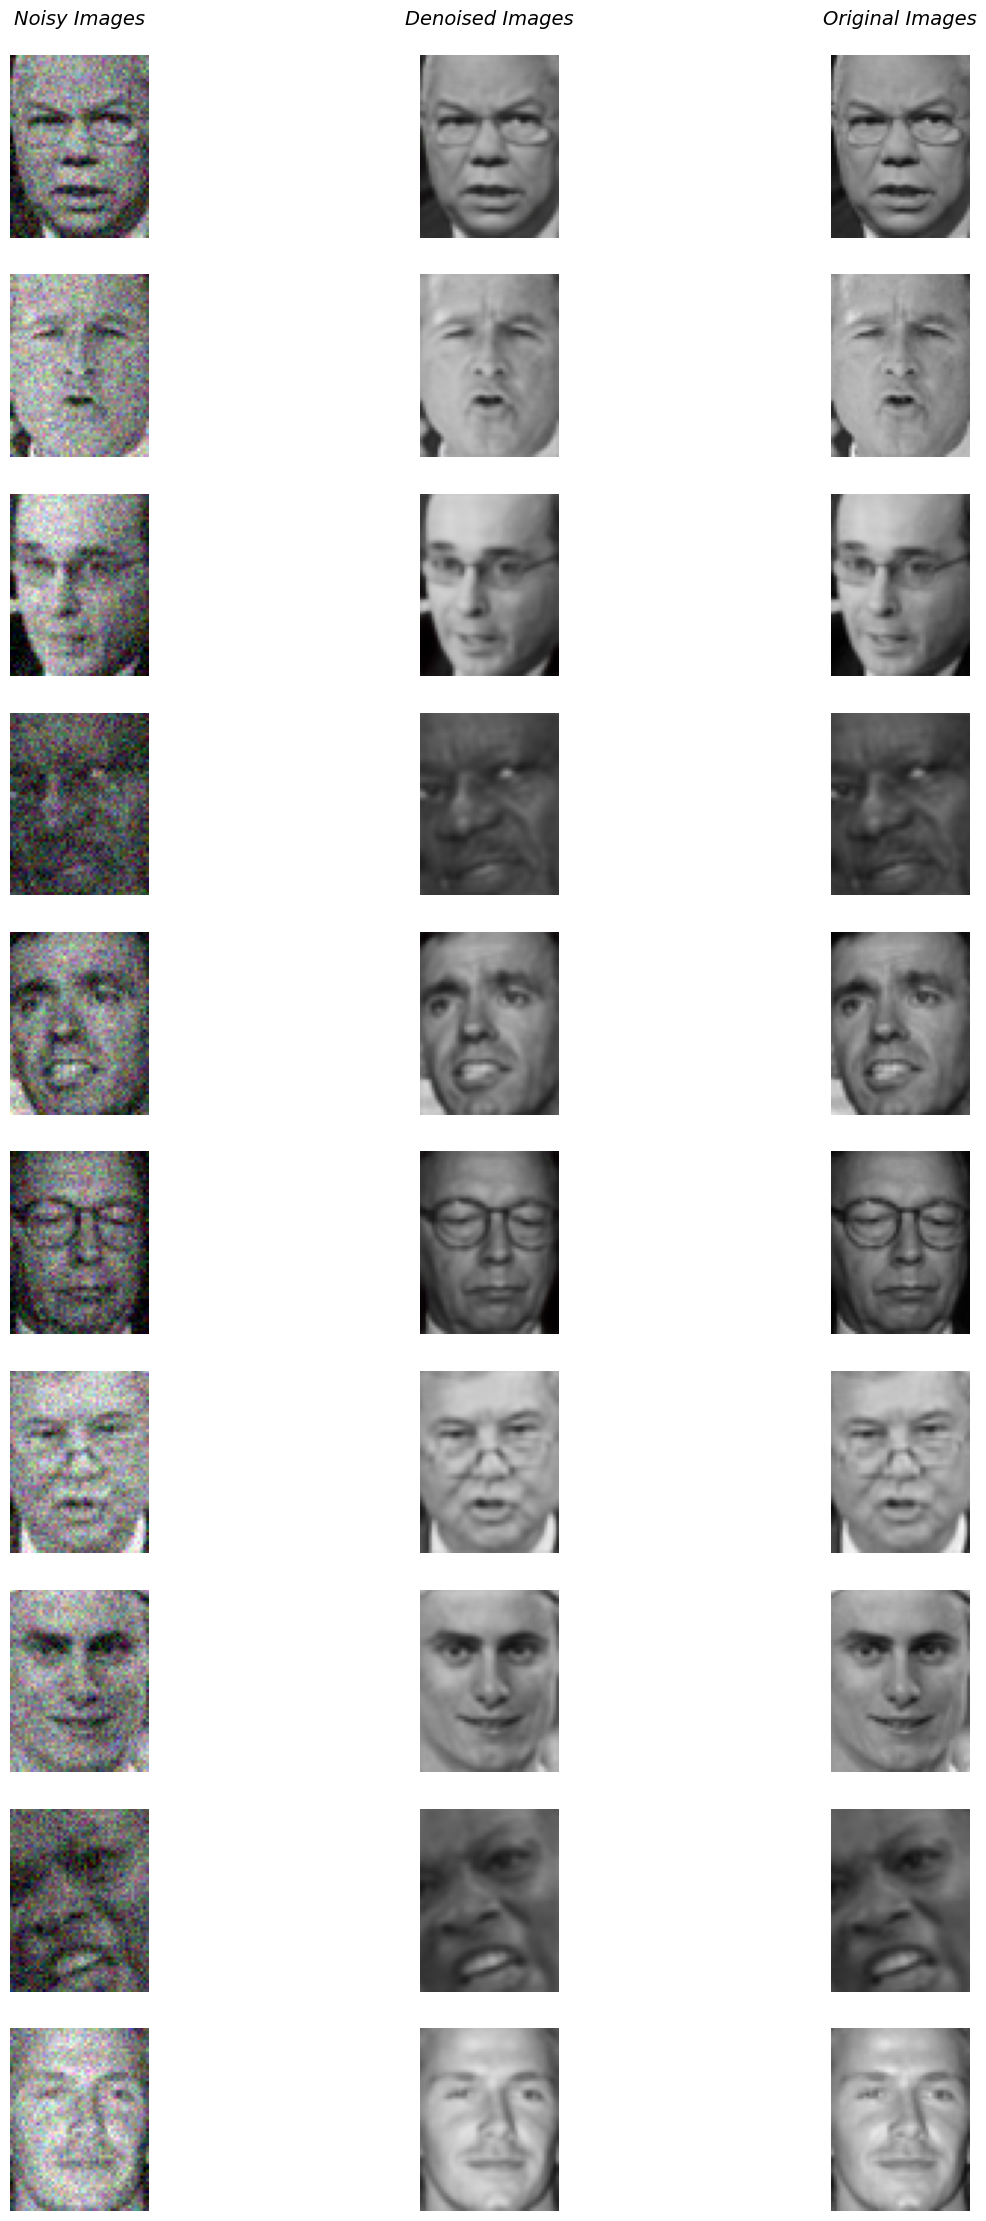

In [ ]:
original = images_rgb[-10:]

f, ax = plt.subplots(10, 3, figsize = (15, 28))
for i in range(10):
    ax[i, 0].imshow(Yte[i])
    ax[i, 1].imshow(denoised_images[i])
    ax[i, 2].imshow(original[i])
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')

ax[0, 0].set_title('Noisy Images\n', fontsize = 14, fontstyle = 'italic')
ax[0, 1].set_title('Denoised Images\n', fontsize = 14,fontstyle = 'italic')
ax[0, 2].set_title('Original Images\n', fontsize = 14,fontstyle = 'italic')
plt.show()
